# Resume Matching Application

This project explores how effectively a candidate's resume aligns with a given job description using Natural Language Processing (NLP) techniques.

The primary objective is to analyze and extract meaningful insights from resume and job description text to support automated resume screening, skill matching, and profile scoring.

## Objectives

- Understand the structure and content of resumes and job descriptions.
- Extract technical and soft skills from both data sources.
- Measure overlap between resume content and job requirements.
- Identify common patterns, gaps, and potential matches using text-based analysis.
- Develop metrics such as skill coverage, similarity scores, and entity extraction.

## Key Components

- Text preprocessing and tokenization
- Skill and keyword extraction (technical and soft skills)
- N-gram and TF-IDF analysis
- Cosine similarity for resume-job matching
- Named Entity Recognition (NER) for education, organizations, degrees, etc.
- Visualization of key findings

This EDA serves as a foundation for building a more robust resume-job match engine that can be integrated into hiring workflows or career guidance tools.



## Section 1: Data

### Resumes and job descriptions are stored in the `data/` folder.

This program accepts the following file formats:
- PDF (`.pdf`)
- Microsoft Word (`.docx`)
- Plain text (`.txt`)


In [31]:
resume_path = "data/resumes"
job_description_path = "data/job_descriptions"

In [32]:
# Importing the necessary libraries

import pdfplumber
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import string

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/amiteshsinha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amiteshsinha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Section 2: Pre-processing

### Loading and Extracting Resume Data

The program automatically loads resumes from the supported file formats:

- PDF (`.pdf`)
- Word Document (`.docx`)
- Plain Text (`.txt`)

It extracts raw text content from each resume to prepare for downstream analysis.


In [33]:
import os
from docx import Document
import pdfplumber

def extract_text_from_docx(path):
    doc = Document(path)
    return "\n".join([para.text for para in doc.paragraphs])

def extract_text_from_pdf(path):
    text = ""
    with pdfplumber.open(path) as pdf:
        for page in pdf.pages:
            text += page.extract_text() or ""
    return text

def read_resumes(folder_path):
    resume_texts = {}

    for filename in os.listdir(folder_path):
        # Skip temp/system files
        if filename.startswith("~$") or filename.startswith("~") or filename.startswith("."):
            continue

        file_path = os.path.join(folder_path, filename)

        if filename.lower().endswith(".docx"):
            text = extract_text_from_docx(file_path)
        elif filename.lower().endswith(".pdf"):
            text = extract_text_from_pdf(file_path)
        elif filename.lower().endswith(".txt"):
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
        else:
            print(f"Unsupported file format or skipped: {filename}")
            continue

        resume_texts[filename] = text

    return resume_texts

resumes = read_resumes(resume_path)


### Reading Job Description

In this example, only a single job description is used to compare against all resumes.  
In future versions, the system can be extended to compare each resume against multiple job descriptions to identify the best fit.


In [34]:
def read_all_job_descriptions(folder_path):
    job_descriptions = {}

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Only read .txt files (you can expand this list if needed)
        if filename.lower().endswith(('.txt', '.md', '.log')):
            try:
                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read()
                    job_descriptions[filename] = content
                    print(f"\n--- {filename} ---")
                    print(content[:50])  # Print first 50 characters as a preview
            except Exception as e:
                print(f"Error reading {filename}: {e}")

    return job_descriptions

all_jobs = read_all_job_descriptions(job_description_path)



--- Quality Assurance Engineer.txt ---
Qualifications
Software Engineer/QA (RAD210401)wit


## Section 3: Exploratory Data Analysis

#### 1. Basic Statistics

- Total number of resumes and job descriptions
- Average word count per resume and per job description
- Distribution of document lengths


In [35]:
import os
import pandas as pd

def build_text_dataframe(folder_path, default_role=None):
    data = {
        "filename": [],
        "text": [],
        "role": []
    }

    for filename in os.listdir(folder_path):
        if filename.endswith(('.txt', '.pdf', '.docx')):  # Adjust if already plain text
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()

            # Try to infer role from filename if not provided
            inferred_role = (
                filename.split("_")[0].replace("-", " ").title()  # e.g., qa-engineer_01.txt → Qa Engineer
                if default_role is None else default_role
            )

            data["filename"].append(filename)
            data["text"].append(content)
            data["role"].append(inferred_role)

    return pd.DataFrame(data)

# Replace these with your actual folder paths
resume_folder = "data/resumes/"
job_folder = "data/job_descriptions/"

# Build DataFrames
resume_df = build_text_dataframe(resume_folder)
job_df = build_text_dataframe(job_folder)


In [36]:

# Add word count columns
resume_df["word_count"] = resume_df["text"].apply(lambda x: len(x.split()))
job_df["word_count"] = job_df["text"].apply(lambda x: len(x.split()))

# 1. Total counts
print(f"Total Resumes: {len(resume_df)}")
print(f"Total Job Descriptions: {len(job_df)}")

# 2. Average word count
print(f"Avg words per Resume: {resume_df['word_count'].mean():.2f}")
print(f"Avg words per Job Description: {job_df['word_count'].mean():.2f}")


Total Resumes: 6
Total Job Descriptions: 1
Avg words per Resume: 1212.00
Avg words per Job Description: 156.00


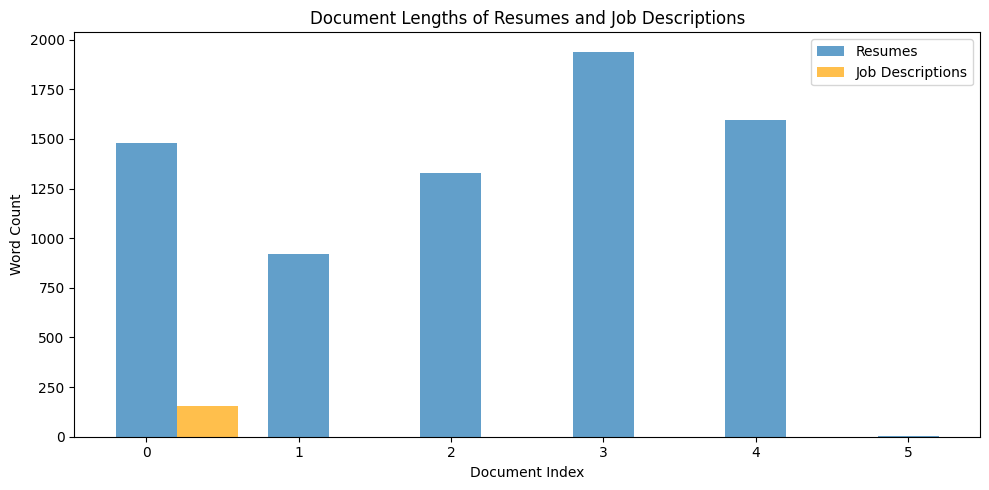

In [37]:
# Bar plot: Document lengths
plt.figure(figsize=(10, 5))

# Plot resumes
plt.bar(
    x=np.arange(len(resume_df)),
    height=resume_df["word_count"],
    alpha=0.7,
    label="Resumes",
    width=0.4
)

# Plot job descriptions with offset
plt.bar(
    x=np.arange(len(job_df)) + 0.4,
    height=job_df["word_count"],
    alpha=0.7,
    label="Job Descriptions",
    width=0.4,
    color="orange"
)

plt.xlabel("Document Index")
plt.ylabel("Word Count")
plt.title("Document Lengths of Resumes and Job Descriptions")
plt.xticks(ticks=np.arange(max(len(resume_df), len(job_df))))
plt.legend()
plt.tight_layout()
plt.show()

### 2. Vocabulary Insights
Most common words (after stopword removal)

Unique word counts

TF (term frequency) and TF-IDF scores

Word clouds for resumes vs. job descriptions (visualize emphasis differences)



In [38]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import re
def clean_and_tokenize_text_column(df, text_column):
    nltk_stopwords = set(stopwords.words('english'))

    # Custom stopwords and patterns (extend as needed)
    custom_stopwords = set([
        'obj', 'n', 'e', 'nan', 'none', 'stream', 'adobe', 'identity', 'qa', 'iu', 'ul', 'true', 'rr',
        'dz', 'sh', 'kc', 'ea', 'za', 'lr', 'sx', 'ji', 'ka', 'jh', 'ef', 'wd',
        'https', 'www', 'google', 'docs', 'com', 'renderer', 'file', 'click', 'version', 'pdf',
        'sckne', 'tdq', 'wst', 'rcyw', 'wen'
    ])

    def is_custom_stopword(word):
        return (
            word in custom_stopwords or
            re.match(r"^end.*", word)  # words starting with 'end'
        )

    def is_clean_word(word):
        return (
            word.isalpha() and
            len(word) > 2 and
            word.isascii() and
            not is_custom_stopword(word) and
            word not in nltk_stopwords
        )
    def is_valid_token(word):
        return (
            word.isalpha() and
            len(word) > 2 and
            word.isascii() and  # Must contain vowels
            not is_custom_stopword(word) and is_clean_word(word)
        )


    # Apply to dataframe column
    return df[text_column].apply(lambda text: [
        word for word in word_tokenize(text.lower()) if is_valid_token(word)
    ])


# Apply to DataFrames
resume_df["tokens"] = clean_and_tokenize_text_column(resume_df, "text")
job_df["tokens"] = clean_and_tokenize_text_column(job_df, "text")

# Preview tokenized results
resume_df[["filename", "tokens"]].head(), job_df[["filename", "tokens"]].head()


(       filename                                             tokens
 0  resume_5.txt  [sange, mugham, professional, summary, seasone...
 1  resume_4.txt  [man, sung, summary, business, analyst, lookin...
 2  resume_1.txt  [jane, austin, experienced, tester, developing...
 3   resume2.txt  [amitesh, sinha, amiteshks, linkedin, github, ...
 4  resume_3.txt  [amish, gupta, dublin, phone, email, aaa, work...,
                          filename  \
 0  Quality Assurance Engineer.txt   
 
                                               tokens  
 0  [qualifications, software, master, degree, com...  )

In [39]:
len(resume_df.iloc[0]["tokens"])

952

### 3. Word Cloud Visualization

Generate word clouds to visualize the most frequent terms across:

- All resumes
- The job description

This helps identify prominent keywords, common themes, and potential alignment between resumes and job requirements.


resume_common_words
resume_unique_count {'duplicate', 'seeking', 'organization', 'formally', 'web', 'corporation', 'continuous', 'simulink', 'terraform', 'sagemaker', 'coordination', 'man', 'algorithm', 'competencies', 'retraining', 'participated', 'jenkins', 'met', 'html', 'aws', 'payment', 'case', 'sql', 'failures', 'scheme', 'conducting', 'kenovate', 'object', 'took', 'reinforcement', 'plans', 'core', 'architect', 'retail', 'prioritizing', 'screens', 'iis', 'strategic', 'regression', 'oriented', 'exchange', 'sun', 'port', 'documentation', 'logistic', 'security', 'overseeing', 'caresoft', 'fpga', 'modeling', 'fund', 'inefficiencies', 'issues', 'advanced', 'defining', 'features', 'isolation', 'authority', 'organizations', 'institute', 'mac', 'make', 'signal', 'dynamic', 'prototype', 'merchant', 'defect', 'home', 'http', 'app', 'language', 'page', 'october', 'high', 'maintaining', 'federal', 'develop', 'measure', 'puts', 'complex', 'analog', 'ruby', 'party', 'visweswaraya', 'actionable

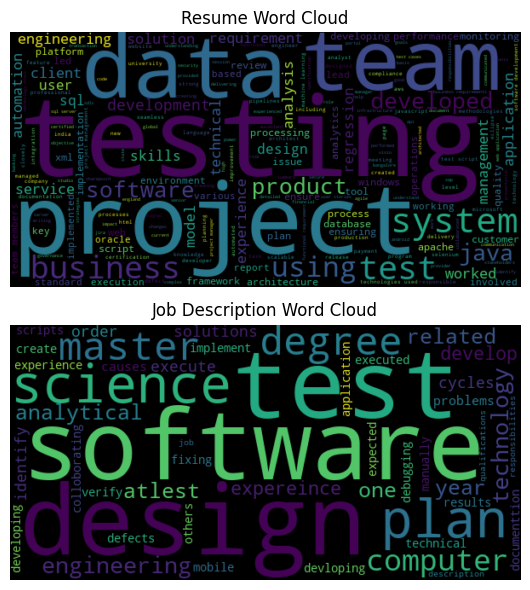

,Metric,Value
0,Most Common Resume Words,"testing(79), data(59), project(58), test(51), ..."
1,Most Common JD Words,"software(6), design(6), test(6), science(4), m..."
2,Unique Resume Words,1613
3,Unique JD Words,49


In [40]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Convert token lists to text
resume_text_cleaned = [" ".join(tokens) for tokens in resume_df["tokens"]]
job_text_cleaned = [" ".join(tokens) for tokens in job_df["tokens"]]

# Combine all words for counting
resume_all_words = " ".join(resume_text_cleaned).split()
job_all_words = " ".join(job_text_cleaned).split()

# 1. Most common words
resume_common_words = Counter(resume_all_words).most_common(10)
job_common_words = Counter(job_all_words).most_common(10)


print (f"resume_common_words")

# 2. Unique word counts
resume_unique_count = len(set(resume_all_words))
job_unique_count = len(set(job_all_words))

print ("resume_unique_count", set(resume_all_words))

# 3. Term Frequency (TF)
resume_vectorizer = CountVectorizer()
job_vectorizer = CountVectorizer()

resume_tf_matrix = resume_vectorizer.fit_transform(resume_text_cleaned)
job_tf_matrix = job_vectorizer.fit_transform(job_text_cleaned)

resume_tf_df = pd.DataFrame(resume_tf_matrix.toarray(), columns=resume_vectorizer.get_feature_names_out())
job_tf_df = pd.DataFrame(job_tf_matrix.toarray(), columns=job_vectorizer.get_feature_names_out())


# 4. TF-IDF

resume_vectorizer = TfidfVectorizer()
job_vectorizer = TfidfVectorizer()
resume_tfidf_matrix = resume_vectorizer.fit_transform(resume_text_cleaned)
job_tfidf_matrix = job_vectorizer.fit_transform(job_text_cleaned)

resume_tfidf_df = pd.DataFrame(resume_tfidf_matrix.toarray(), columns=resume_vectorizer.get_feature_names_out())
job_tfidf_df = pd.DataFrame(job_tfidf_matrix.toarray(), columns=job_vectorizer.get_feature_names_out())

# 5. Word Clouds
resume_wordcloud = WordCloud(width=600, height=300).generate(" ".join(resume_all_words))
job_wordcloud = WordCloud(width=600, height=300).generate(" ".join(job_all_words))

# Display word clouds
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.imshow(resume_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Resume Word Cloud")

plt.subplot(2, 1, 2)
plt.imshow(job_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Job Description Word Cloud")
plt.tight_layout()
plt.show()

# Display summary insights
summary = {
    "Metric": ["Most Common Resume Words", "Most Common JD Words", "Unique Resume Words", "Unique JD Words"],
    "Value": [
        ", ".join([f"{word}({count})" for word, count in resume_common_words]),
        ", ".join([f"{word}({count})" for word, count in job_common_words]),
        resume_unique_count,
        job_unique_count
    ]
}

summary_df = pd.DataFrame(summary)
display(summary_df)


### 4. Most Commonly Used Terms

Display the most frequent words found in:

- Resumes
- Job description


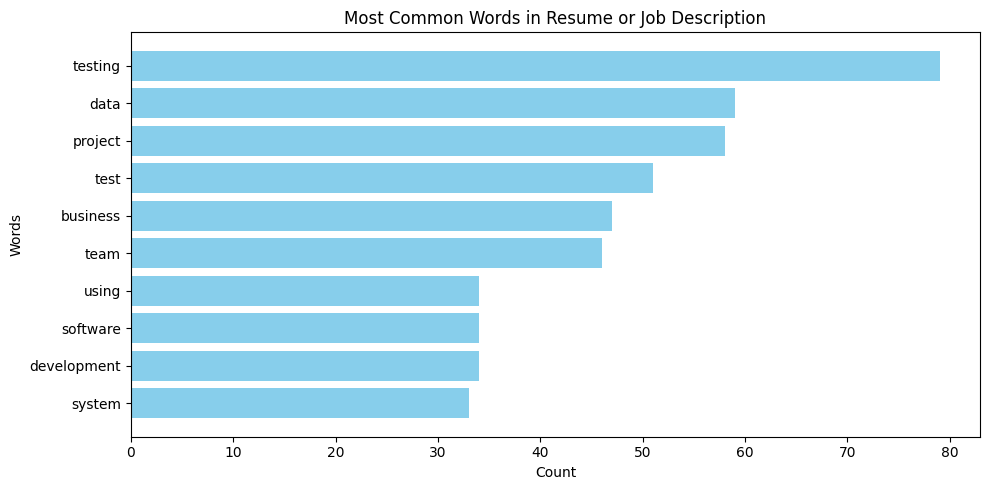

In [41]:

data_str = summary_df['Value'][0]

# Parse it into word and count
word_counts = [item.strip().split('(') for item in data_str.split(',')]
words = [word for word, _ in word_counts]
counts = [int(count.strip(')')) for _, count in word_counts]

# Plotting
plt.figure(figsize=(10, 5))
plt.barh(words, counts, color='skyblue')
plt.xlabel("Count")
plt.ylabel("Words")
plt.title("Most Common Words in Resume or Job Description")
plt.gca().invert_yaxis()  # Optional: Highest count at top
plt.tight_layout()
plt.show()


### 5. Resume vs. Job Description: Skill Comparison

- Top technical and soft skills mentioned in resumes
- Top required skills extracted from the job description
- Skills overlap: percentage of common skills between resumes and the job description

This section evaluates how well the resumes align with the job requirements based on keyword and skill matching.


In [42]:

technical_skills = [
    'testing',
    'debugging',
    'manual testing',
    'scripts',
    'tracking',
    'qa',
    'implementation',
    'engineering',
    'computer science'
]
soft_skills = [
    'collaboration',
    'problem-solving',
    
    'communication',
    'planning',
    'teamwork',
    'analytical thinking',
    'documentation'
]
def check_skills(resume_tokens, skill_set):
    text = " ".join(resume_tokens).lower()
    matched_skills = [skill for skill in skill_set if skill.lower() in text]
    return len(matched_skills), matched_skills

resume_matching_summaries = []  # initialize list before the loop

for index, resume_data in resume_df.iterrows():
    tokens = resume_data["tokens"]

    # Initialize per-resume summary
    resume_matching_summary = {
        "File_Name": '',
        "Matching_score": 0,
        "Hard_skills_matching_count": 0,
        "Soft_skills_matching_count": 0,
        "Hard_skills_matching_score": 0,
        "Soft_skills_matching_score": 0,
        "Hard_skills_matched": [],
        "Soft_skills_matched": []
    }

    # Match skills
    hard_skills_matching_count, matched_hard_skills = check_skills(tokens, technical_skills)
    soft_skills_matching_count, matched_soft_skills = check_skills(tokens, soft_skills)

    # Individual skill scores
    hard_skills_matching_score = hard_skills_matching_count / len(technical_skills)
    soft_skills_matching_score = soft_skills_matching_count / len(soft_skills)

    # Overall score
    matching_score = 100 * (hard_skills_matching_count + soft_skills_matching_count) / (len(technical_skills) + len(soft_skills))

    # Populate summary
    resume_matching_summary["File_Name"] = resume_data["filename"]
    resume_matching_summary["Hard_skills_matching_count"] = hard_skills_matching_count
    resume_matching_summary["Soft_skills_matching_count"] = soft_skills_matching_count
    resume_matching_summary["Hard_skills_matching_score"] = round(hard_skills_matching_score, 4)
    resume_matching_summary["Soft_skills_matching_score"] = round(soft_skills_matching_score, 4)
    resume_matching_summary["Hard_skills_matched"] = matched_hard_skills
    resume_matching_summary["Soft_skills_matched"] = matched_soft_skills
    resume_matching_summary["Matching_score"] = round(matching_score, 4) 

    resume_matching_summaries.append(resume_matching_summary)



# Convert to DataFrame
resume_match_df = pd.DataFrame(resume_matching_summaries)

# Display the result
resume_match_df



,File_Name,Matching_score,Hard_skills_matching_count,Soft_skills_matching_count,Hard_skills_matching_score,Soft_skills_matching_score,Hard_skills_matched,Soft_skills_matched
0,resume_5.txt,43.75,4,3,0.4444,0.4286,"[testing, debugging, tracking, implementation]","[communication, planning, documentation]"
1,resume_4.txt,31.25,3,2,0.3333,0.2857,"[testing, implementation, engineering]","[communication, documentation]"
2,resume_1.txt,43.75,3,4,0.3333,0.5714,"[testing, tracking, implementation]","[communication, planning, teamwork, documentat..."
3,resume2.txt,50.00,5,3,0.5556,0.4286,"[testing, tracking, implementation, engineerin...","[collaboration, communication, planning]"
4,resume_3.txt,43.75,5,2,0.5556,0.2857,"[testing, scripts, tracking, qa, engineering]","[planning, documentation]"
5,~$sume_5.docx,0.00,0,0,0.0000,0.0000,[],[]


#### 6. Compare Resume Fitness Against the Job Description

Evaluate how well each resume in the dataset aligns with the job description based on matching skills and keywords.  
This helps identify the best-fitting candidates from the corpus.


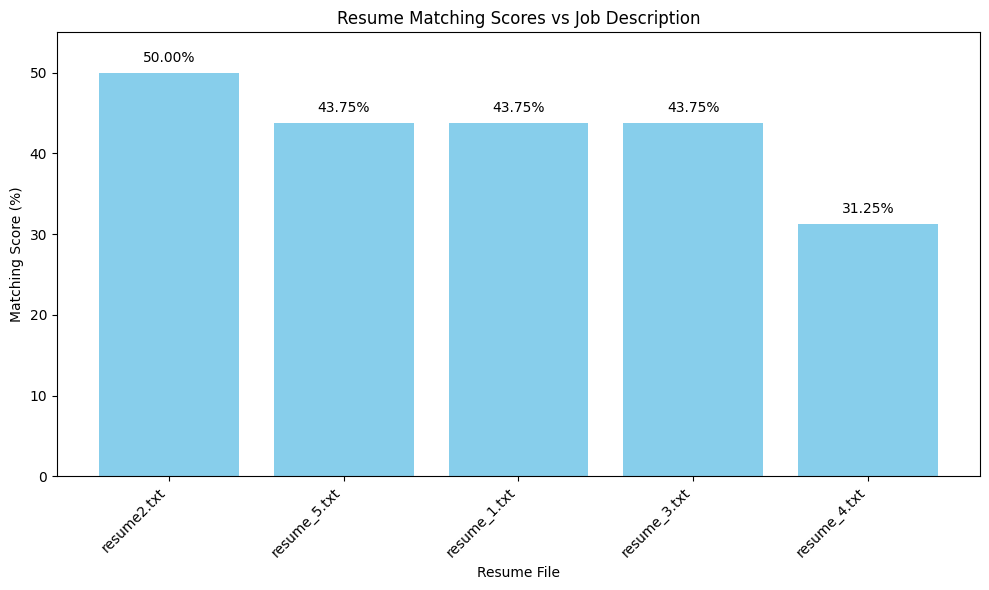

In [43]:
import matplotlib.pyplot as plt

# Step 1: Filter out unwanted/system files (e.g., '~$')
filtered_df = resume_match_df[~resume_match_df["File_Name"].str.startswith("~")].copy()

# Step 2: Sort by Matching Score descending
filtered_df = filtered_df.sort_values("Matching_score", ascending=False)

# Step 3: Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(filtered_df["File_Name"], filtered_df["Matching_score"], color='skyblue')

# Step 4: Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{height:.2f}%", ha='center', va='bottom')

# Step 5: Chart settings
plt.ylabel("Matching Score (%)")
plt.xlabel("Resume File")
plt.title("Resume Matching Scores vs Job Description")
plt.ylim(0, min(105, filtered_df["Matching_score"].max() + 5))  # Dynamic max limit
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [44]:
resume_match_df[["File_Name", "Matching_score",  "Hard_skills_matching_score", "Soft_skills_matching_score"]][:5]


,File_Name,Matching_score,Hard_skills_matching_score,Soft_skills_matching_score
0,resume_5.txt,43.75,0.4444,0.4286
1,resume_4.txt,31.25,0.3333,0.2857
2,resume_1.txt,43.75,0.3333,0.5714
3,resume2.txt,50.00,0.5556,0.4286
4,resume_3.txt,43.75,0.5556,0.2857
